In [1]:
import shnitsel as sh
import shnitsel.xarray
import xarray as xr
from IPython.display import display, Image


In [2]:
A01 = sh.open_frames('/nc/reports/2025-05-21_datasheets/filtered_C2H4.nc')
I01 = sh.open_frames('/nc/SHNITSEL_databases/dynamic/I01_ch2nh2_dynamic.nc')
A02 = sh.open_frames('/nc/reports/2025-05-21_datasheets/filtered_C3H6.nc')
A03 = sh.open_frames('/nc/reports/2025-05-21_datasheets/filtered_C4H8_g0.nc')

# Previously, we extracted substructures before filtering, but this is only required for
# "PCA across compounds" (and "PCA across angles", if this is to be included).
# A02new = A02.isel(atom=slice(0,6)).assign_coords(atom=[0, 1, 2, 3, 5, 4]).sortby('atom')
# A03new = A03.isel(atom=[0,1,2,3,7,8]).assign_coords(atom=[3, 1, 0, 2, 4, 5]).sortby('atom')

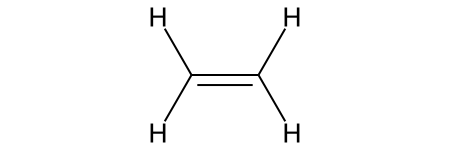

In [3]:
mol = A01.atXYZ.isel(frame=0).sh.to_mol()
mol

In [4]:
bonds = sh.dynamic.filter_unphysical.find_bonds_by_element(mol, 6, 6)
bonds = sh.dynamic.filter_unphysical.find_bonds_by_element(mol, 1, 6)
bonds

[(0, 2), (0, 5), (1, 3), (1, 4)]

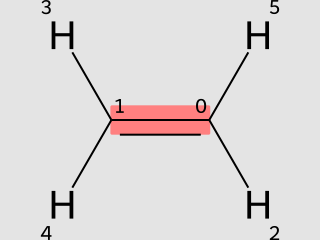

In [5]:
display(Image(sh.dynamic.filter_unphysical.show_bonds_mol(mol, 6, 6, True)))

In [6]:
def bond_type_to_symbols(e1, e2):
    s1 = sh.parse.common.__atnum2symbol__[e1]
    s2 = sh.parse.common.__atnum2symbol__[e2]
    return s1 + s2


In [7]:
def get_bond_types(mol, symbols=True):
    bond_types = {}
    for b in mol.GetBonds():
        a1 = b.GetBeginAtom()
        a2 = b.GetEndAtom()
        indices = (a1.GetIdx(), a2.GetIdx())
        elements = tuple(sorted([a1.GetAtomicNum(), a2.GetAtomicNum()]))
        if elements not in bond_types:
            bond_types[elements] = []
        bond_types[elements].append(indices)
    if symbols:
        bond_types = {
            bond_type_to_symbols(*k): v for k, v in bond_types.items()
        }
    return bond_types

bond_types = get_bond_types(mol)
bond_types

{'CC': [(0, 1)], 'HC': [(0, 2), (0, 5), (1, 3), (1, 4)]}

In [8]:
dists = A01.atXYZ.sh.subtract_combinations('atom', labels=True).sh.norm()
dists

<xarray.DataArray (atomcomb: 15, frame: 62031)> Size: 7MB
array([[1.34517946, 1.35167321, 1.35899658, ..., 7.10717786, 7.12481371,
        7.14361786],
       [1.13050448, 1.11766826, 1.10153534, ..., 1.29207555, 1.27515023,
        1.25142808],
       [1.97807253, 2.00833229, 2.0540353 , ..., 7.14391471, 7.1551863 ,
        7.16526953],
       ...,
       [1.80253552, 1.82526038, 1.85919207, ..., 1.56546647, 1.60078555,
        1.63989675],
       [2.86438682, 2.88767066, 2.93184765, ..., 8.02916135, 8.04207948,
        8.04881959],
       [2.33257396, 2.33677163, 2.34617471, ..., 9.17585093, 9.20464736,
        9.22691646]], shape=(15, 62031))
Coordinates:
  * atomcomb  (atomcomb) object 120B MultiIndex
  * from      (atomcomb) int64 120B 0 0 0 0 0 1 1 1 1 2 2 2 3 3 4
  * to        (atomcomb) int64 120B 1 2 3 4 5 2 3 4 5 3 4 5 4 5 5
  * frame     (frame) object 496kB MultiIndex
  * trajid    (frame) int64 496kB 2 2 2 2 2 2 2 ... 962 962 962 962 962 962 962
  * time      (frame) float64 496kB 0.0 0.5 1.0 1.5 ... 167.0 167.5 168.0 168.5

In [52]:
def get_bond_lengths(frames, bond_types=None, mol=None):
    dists = frames.atXYZ.sh.subtract_combinations('atom', labels=True).sh.norm()
    if bond_types is None:
        if mol is None:
            mol = frames.sh.default_mol()
        if mol is None:
            raise ValueError(
                "Failed to get default mol, please set a smiles map. "
                "For example, if the compound has charge c and frame i contains a representative geometry, use "
                "frames.attrs['smiles_map'] = frames.atXYZ.isel(frame=i).sh.get_smiles_map(charge=c)"
            )
        bond_types = get_bond_types(mol, symbols=True)
    return xr.concat(
        [
            dists.sel(atomcomb=bonds).sh.expand_midx('atomcomb', 'bond_type', bond_type)
            for bond_type, bonds in bond_types.items()
        ],
        dim='atomcomb'
    ).rename({'from': 'atom1', 'to': 'atom2', 'atomcomb': 'bond'}).transpose('frame', ...)

lengths = get_bond_lengths(A01)
lengths

<xarray.DataArray (frame: 62031, bond: 5)> Size: 2MB
array([[1.34517946, 1.13050448, 1.05540845, 0.93322882, 1.1162366 ],
       [1.35167321, 1.11766826, 1.044994  , 0.95831056, 1.11812979],
       [1.35899658, 1.10153534, 1.03910828, 1.00143008, 1.11657425],
       ...,
       [7.10717786, 1.29207555, 1.1900943 , 1.08906804, 1.14459848],
       [7.12481371, 1.27515023, 1.18119096, 1.08619924, 1.1605664 ],
       [7.14361786, 1.25142808, 1.16852549, 1.08623084, 1.17408787]],
      shape=(62031, 5))
Coordinates:
  * frame      (frame) object 496kB MultiIndex
  * trajid     (frame) int64 496kB 2 2 2 2 2 2 2 ... 962 962 962 962 962 962 962
  * time       (frame) float64 496kB 0.0 0.5 1.0 1.5 ... 167.0 167.5 168.0 168.5
  * bond       (bond) object 40B MultiIndex
  * bond_type  (bond) object 40B 'CC' 'HC' 'HC' 'HC' 'HC'
  * atom1      (bond) int64 40B 0 0 0 1 1
  * atom2      (bond) int64 40B 1 2 5 3 4

In [10]:
limits_by_type = xr.DataArray([1.5, 2], coords=[('bond_type', ['CC', 'HC'])])
limits_by_type

<xarray.DataArray (bond_type: 2)> Size: 16B
array([1.5, 2. ])
Coordinates:
  * bond_type  (bond_type) <U2 16B 'CC' 'HC'

In [11]:
limits_by_bond = limits_by_type.sel(bond_type=lengths.bond_type).reset_index(['atom1', 'atom2']).set_xindex(['bond_type', 'atom1', 'atom2'])
limits_by_bond

<xarray.DataArray (bond: 5)> Size: 40B
array([1.5, 2. , 2. , 2. , 2. ])
Coordinates:
  * bond       (bond) object 40B MultiIndex
  * bond_type  (bond) <U2 40B 'CC' 'HC' 'HC' 'HC' 'HC'
  * atom1      (bond) int64 40B 0 0 0 1 1
  * atom2      (bond) int64 40B 1 2 5 3 4

In [12]:
limits_by_type = xr.DataArray([1.5, 2], coords=[('bond_type', ['CC', 'HC'])])

In [13]:
cutoffs = (lengths < limits_by_bond).sh.last_time_where()
cutoffs

<xarray.DataArray 'time' (trajid: 297, bond: 5)> Size: 12kB
array([[ 44.5,  83.5,  83.5,  83.5,  83.5],
       [ 26.5,  82.5, 109. , 109. ,  40. ],
       [ 26. ,  94. ,  94. ,  72.5,  94. ],
       ...,
       [  8. ,  72.5,  40.5,  72.5,  72.5],
       [ 23. ,  81. ,  81. ,  81. ,  81. ],
       [  4.5, 168.5, 168.5, 168.5, 168.5]], shape=(297, 5))
Coordinates:
  * trajid     (trajid) int64 2kB 2 3 4 8 10 11 15 ... 950 951 956 957 961 962
  * bond       (bond) object 40B MultiIndex
  * bond_type  (bond) object 40B 'CC' 'HC' 'HC' 'HC' 'HC'
  * atom1      (bond) int64 40B 0 0 0 1 1
  * atom2      (bond) int64 40B 1 2 5 3 4

In [90]:
I01.attrs['smiles_map'] = I01.atXYZ.isel(frame=0).sh.smiles_map(+1)
I01.attrs['smiles_map']

'[C:0](=[N+:1]([H:3])[H:4])([H:2])[H:5]'

In [98]:
limits_by_type = xr.DataArray([1.5, 2, 3, 2], coords=[('bond_type', ['CC', 'HC', 'CN', 'HN'])])
cpnds = {'I01': I01, 'A01': A01, 'A02': A02, 'A03': A03}
cutoffs = {}
masks = {}
for cpnd in cpnds:
    lengths = get_bond_lengths(cpnds[cpnd])
    al = ['atom1', 'atom2']
    limits_by_bond = (
        limits_by_type
        .sel(bond_type=lengths.bond_type)
        .reset_index(al).set_xindex(['bond_type', *al])
    )
    masks[cpnd] = (lengths < limits_by_bond)
    cutoffs[cpnd] = masks[cpnd].sh.last_time_where().rename(bond='cutoff')
    cutoffs[cpnd]['original'] = lengths.time.groupby('trajid').last()
    cutoffs[cpnd]['earliest'] = cutoffs[cpnd].min('cutoff')

In [99]:
cutoffs['A01'] #.rename(bond='cutoff')

<xarray.DataArray 'time' (trajid: 297, cutoff: 5)> Size: 12kB
array([[ 44.5,  83.5,  83.5,  83.5,  83.5],
       [ 26.5,  82.5, 109. , 109. ,  40. ],
       [ 26. ,  94. ,  94. ,  72.5,  94. ],
       ...,
       [  8. ,  72.5,  40.5,  72.5,  72.5],
       [ 23. ,  81. ,  81. ,  81. ,  81. ],
       [  4.5, 168.5, 168.5, 168.5, 168.5]], shape=(297, 5))
Coordinates:
  * trajid     (trajid) int64 2kB 2 3 4 8 10 11 15 ... 950 951 956 957 961 962
  * cutoff     (cutoff) object 40B MultiIndex
  * bond_type  (cutoff) object 40B 'CC' 'HC' 'HC' 'HC' 'HC'
  * atom1      (cutoff) int64 40B 0 0 0 1 1
  * atom2      (cutoff) int64 40B 1 2 5 3 4
    original   (trajid) float64 2kB 83.5 109.0 94.0 199.5 ... 72.5 81.0 168.5
    earliest   (trajid) float64 2kB 44.5 26.5 26.0 28.0 4.5 ... 9.0 8.0 23.0 4.5

## Which bond breaks first, how often?

In [100]:
import numpy as np

co = cutoffs['A03']
nreasons = co.sizes['cutoff']
typefreqs = np.bincount(co.argmin('cutoff'), minlength=nreasons)
typefreqs

array([102,  13,  41,   0,   0,   0,   0,   0,   0,   0,   0])

In [101]:
display_data = co['cutoff'].copy(data=typefreqs)
display_data = 100*display_data / display_data.sum()

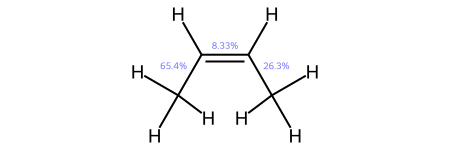

In [102]:
mol = A03.sh.default_mol()

def label_bonds(mol, da):
    for b in mol.GetBonds():
        ai1 = b.GetBeginAtom().GetIdx()
        ai2 = b.GetEndAtom().GetIdx()
        datum = da.sel(atom1=ai1, atom2=ai2).item()
        if datum != 0:
            b.SetProp("bondNote", f"{datum:.3}%")
    return mol

label_bonds(mol, display_data)

In [114]:
sh.pca_biplot

AttributeError: module 'shnitsel' has no attribute 'pca_biplot'

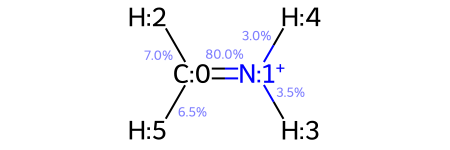

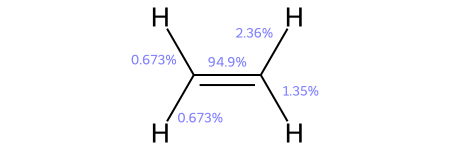

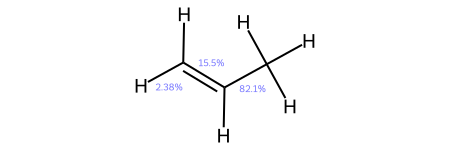

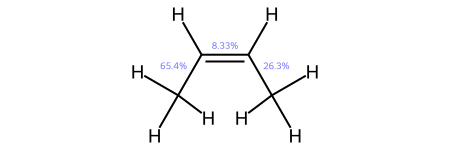

In [ ]:


for (cn, co) in cutoffs.items():
    nreasons = co.sizes['cutoff']
    typefreqs = np.bincount(co.argmin('cutoff'), minlength=nreasons)
    display_data = co['cutoff'].copy(data=typefreqs)
    display_data = 100*display_data / display_data.sum()
    mol = cpnds[cn].sh.default_mol()
    display(label_bonds(mol, display_data))



## Which bonds break at all, and how often?

In [107]:
masks['A03'].groupby('trajid').all('frame').sum('trajid')

<xarray.DataArray (bond: 11)> Size: 88B
array([  7,   4,   0, 156, 142, 150, 147, 141, 155, 155, 156])
Coordinates:
  * bond       (bond) object 88B MultiIndex
  * bond_type  (bond) object 88B 'CC' 'CC' 'CC' 'HC' ... 'HC' 'HC' 'HC' 'HC'
  * atom1      (bond) int64 88B 0 1 2 0 0 0 1 2 3 3 3
  * atom2      (bond) int64 88B 1 2 3 4 5 6 7 8 9 10 11

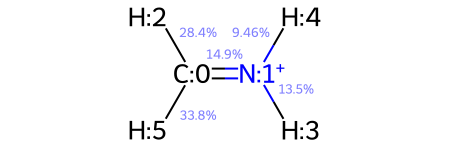

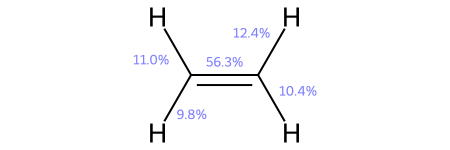

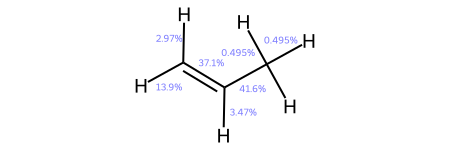

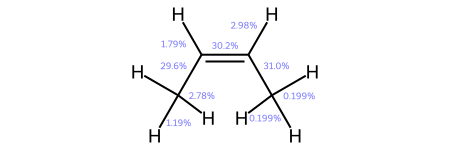

In [113]:
for (cn, mask) in masks.items():
    display_data = (~mask.groupby('trajid').all('frame')).sum('trajid')
    display_data = 100*display_data / display_data.sum()
    mol = cpnds[cn].sh.default_mol()
    display(label_bonds(mol, display_data))


## Other plot, maybe leave out

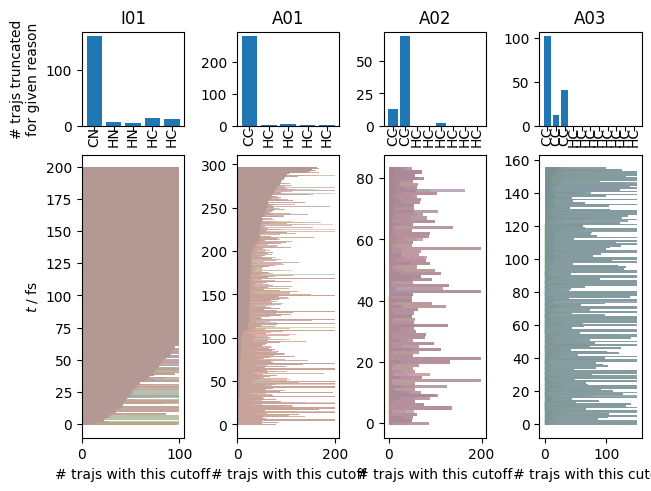

In [50]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 4, sharey=False, constrained_layout=True, height_ratios=[1, 3])
for (cn, c), axcol in zip(cutoffs.items(), axs.T):
    nreasons = c.sizes['cutoff']
    typefreqs = np.bincount(c.argmin('cutoff'), minlength=nreasons)
    xticks = range(nreasons)
    axcol[0].bar(xticks, typefreqs)
    axcol[0].set_xticks(xticks)
    axcol[0].set_xticklabels(labels=c['bond_type'].data, rotation=90, ha='center', va='center')
    axcol[0].set_title(cn)

    c['most_frequent'] = 'trajid', c.isel(cutoff=typefreqs.argmax()).data
    c = c.sortby(['earliest', 'most_frequent'])
    xticks = np.arange(c.sizes['trajid'])
    for ctn, ctv in c.groupby('cutoff'):
        ctv = ctv.squeeze()
        axcol[1].barh(xticks, ctv, height=1.0, alpha=0.2)
    
    axs[0,0].set_ylabel("# trajs truncated\nfor given reason")
    axs[1,0].set_ylabel("$t$ / fs")
    for ax in axs[1, :]:
        ax.set_xlabel("# trajs with this cutoff")

In [ ]:
A01.sh.save_frames('/tmp/I01_intact.nc')
I01.sh.save_frames
A02.sh.save_frames
A03.sh.save_frames

In [ ]:
# TODO
# Original: use substructures
# Filter cleavages
# A01.atXYZ.attrs['smiles_map'] = A01.atXYZ.isel(frame=0).sh.smiles_map()
# I01.atXYZ.attrs['smiles_map'] = I01.atXYZ.isel(frame=0).sh.smiles_map(charge=+1)
# A02new.atXYZ.attrs['smiles_map'] = A02new.atXYZ.isel(frame=0).sh.smiles_map(charge=-3)
# A03new.atXYZ.attrs['smiles_map'] = A03new.atXYZ.isel(frame=0).sh.smiles_map(charge=-8)
# filtration_verbosity = 0
# I01 = sh.dynamic.filter_unphysical.filter_cleavage(I01, CH=True, CN=True, NH=True, verbose=filtration_verbosity)
# A01 = sh.dynamic.filter_unphysical.filter_cleavage(A01, CC=True, CH=True, verbose=filtration_verbosity)
# A02new = sh.dynamic.filter_unphysical.filter_cleavage(A02new, CC=True, CH=True, verbose=filtration_verbosity)
# A03new = sh.dynamic.filter_unphysical.filter_cleavage(A03new, CC=True, CH=True, verbose=filtration_verbosity)